# Comparing models quantitatively and qualitatively

In [24]:
#imports
import os
import json
import time
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import joblib
import optuna
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler as CPU_StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC as CPU_SVC



#set seed + device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [25]:
def get_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

def load_test_dataset(image_dir, label_dir):
    image_paths, labels = [], []
    for fname in sorted(os.listdir(image_dir)):
        if fname.endswith('.jpeg'):
            image_paths.append(os.path.join(image_dir, fname))
            with open(os.path.join(label_dir, fname.replace('.jpeg', '.txt'))) as f:
                labels.append(int(f.read().strip()))
    return image_paths, np.array(labels)

def create_cnn_dataloader(image_paths, labels, batch_size=32):
    def _load(idx):
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return transform(img), labels[idx]

    transform = get_transforms()
    dataset = [ _load(i) for i in range(len(image_paths)) ]
    images, targets = zip(*dataset)
    images = torch.stack(images)
    targets = torch.tensor(targets)
    loader = DataLoader(list(zip(images, targets)), batch_size=batch_size, shuffle=False)
    return loader


In [26]:
def build_cnn_model(backbone='resnet18', num_classes=3):
    class MaskDetectionCNN(nn.Module):
        def __init__(self, backbone, num_classes):
            super().__init__()
            if backbone == 'resnet18':
                base = models.resnet18(weights='IMAGENET1K_V1')
                self.base_model = nn.Sequential(*list(base.children())[:-1])
                features = base.fc.in_features
            elif backbone == 'mobilenet_v2':
                base = models.mobilenet_v2(weights='IMAGENET1K_V1')
                self.base_model = nn.Sequential(base.features, nn.AdaptiveAvgPool2d(1))
                features = base.classifier[1].in_features
            else:
                raise ValueError("Unsupported backbone")

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Dropout(0.5),
                nn.Linear(features, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )

        def forward(self, x):
            x = self.base_model(x)
            x = self.classifier(x)
            return x

    return MaskDetectionCNN(backbone, num_classes).to(device)
    
def evaluate_cnn(model_path, test_img_dir, test_lbl_dir):
    #load data
    image_paths, labels = load_test_dataset(test_img_dir, test_lbl_dir)
    test_loader = create_cnn_dataloader(image_paths, labels)

    #load model
    model = build_cnn_model()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    preds, targets = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            out = model(x_batch)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(y_batch.numpy())

    acc = accuracy_score(targets, preds)
    report = classification_report(targets, preds, target_names=["No Mask", "Mask", "Improper Mask"])
    cm = confusion_matrix(targets, preds)

    print("\nCNN + Transfer Learning Evaluation")
    print(f"Test Accuracy: {acc:.4f}")
    print(report)

    # Confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Mask", "Mask", "Improper Mask"],
                yticklabels=["No Mask", "Mask", "Improper Mask"])
    plt.title("CNN Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [27]:
def extract_hog_features_for_knn(image_paths, orientations, ppc, cpb, stride):
    hog = cv2.HOGDescriptor(
        _winSize=(64, 64),
        _blockSize=(ppc[0]*cpb[0], ppc[1]*cpb[1]),
        _blockStride=stride,
        _cellSize=ppc,
        _nbins=orientations
    )
    features = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        feat = hog.compute(img).flatten()
        features.append(feat)
    return np.array(features)

def evaluate_knn(model_path, scaler_path, params_path, test_img_dir, test_lbl_dir):
    #load test data
    test_paths, test_labels = load_test_dataset(test_img_dir, test_lbl_dir)

    #load model+params
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    params = joblib.load(params_path)

    ppc = (params["ppc_x"], params["ppc_y"])
    cpb = (params["cpb_x"], params["cpb_y"])
    stride = (params["stride_x"], params["stride_y"])
    orientations = params["orientations"]

    #extract n scale features
    hog_features = extract_hog_features_for_knn(test_paths, orientations, ppc, cpb, stride)
    hog_features_scaled = scaler.transform(hog_features)

    preds = model.predict(hog_features_scaled)

    #results
    acc = accuracy_score(test_labels, preds)
    report = classification_report(test_labels, preds, target_names=["No Mask", "Mask", "Improper Mask"])
    cm = confusion_matrix(test_labels, preds)

    print("\nKNN + HOG Evaluation")
    print(f"Test Accuracy: {acc:.4f}")
    print(report)

    #confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Mask", "Mask", "Improper Mask"],
                yticklabels=["No Mask", "Mask", "Improper Mask"])
    plt.title("KNN Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [28]:
def forward_mlp(x, weights):
    x = F.linear(x, weights['w1'], weights['b1'])
    x = F.relu(x)
    x = F.dropout(x, p=weights['dropout'], training=weights['train'])
    x = F.linear(x, weights['w2'], weights['b2'])
    return x
    
def extract_hog_features_for_mlp(image_paths, orientations, ppc, cpb):
    hog = cv2.HOGDescriptor(
        _winSize=(64, 64),
        _blockSize=(ppc[0]*cpb[0], ppc[1]*cpb[1]),
        _blockStride=ppc,
        _cellSize=ppc,
        _nbins=orientations
    )
    features = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        feat = hog.compute(img).flatten()
        features.append(feat)
    return np.array(features)

def evaluate_mlp(model_path, scaler_path, params_path, test_img_dir, test_lbl_dir):
    # Load test data
    test_paths, test_labels = load_test_dataset(test_img_dir, test_lbl_dir)

    
    #load compoenents
    params = joblib.load(params_path)
    scaler = joblib.load(scaler_path)
    model_weights = torch.load(model_path, map_location=device)
    model_weights['train'] = False  # Ensure dropout is off

    #extract HOG features
    orientations = params["orientations"]
    ppc = (params["ppc_x"], params["ppc_y"])
    cpb = (params["cpb_x"], params["cpb_y"])
    features = extract_hog_features_for_mlp(test_paths, orientations, ppc, cpb)
    features_scaled = scaler.transform(features)

    with torch.no_grad():
        X_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
        preds = forward_mlp(X_tensor, model_weights).argmax(1).cpu().numpy()

    acc = accuracy_score(test_labels, preds)
    report = classification_report(test_labels, preds, target_names=["No Mask", "Mask", "Improper Mask"])
    cm = confusion_matrix(test_labels, preds)

    print("\nMLP + HOG Evaluation")
    print(f"Test Accuracy: {acc:.4f}")
    print(report)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Mask", "Mask", "Improper Mask"],
                yticklabels=["No Mask", "Mask", "Improper Mask"])
    plt.title("MLP Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [29]:
try:
    import cupy as cp
    from cuml.svm import SVC as GPU_SVC
    from cuml.preprocessing import StandardScaler as GPU_StandardScaler
    has_gpu = True
    print("GPU acceleration available")
except ImportError:
    has_gpu = False
    print("GPU acceleration not available, using CPU only")
    cp = np
    GPU_SVC = CPU_SVC
    GPU_StandardScaler = CPU_StandardScaler

def to_numpy(arr):
    return cp.asnumpy(arr) if has_gpu and isinstance(arr, cp.ndarray) else arr

def extract_hog_features(image_paths, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    features = []
    for img_path in image_paths:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        hog_features = hog(
            image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            feature_vector=True
        )
        features.append(hog_features)
    return cp.array(features) if has_gpu else np.array(features)


def evaluate_svm(model_path, scaler_path, params_path, test_img_dir, test_lbl_dir):
    #laod components
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    params = joblib.load(params_path)

    #load test data
    test_paths, test_labels = load_test_dataset(test_img_dir, test_lbl_dir)

    #extracting HOG features using saved best params
    orientations = params["orientations"]
    ppc = params["pixels_per_cell"]
    cpb = params["cells_per_block"]

    hog_features = extract_hog_features(test_paths, orientations, ppc, cpb)
    hog_features_scaled = scaler.transform(to_numpy(hog_features))
    test_labels_np = to_numpy(test_labels)

    preds = model.predict(hog_features_scaled)

    #report
    acc = accuracy_score(test_labels_np, preds)
    report = classification_report(test_labels_np, preds, target_names=["No Mask", "Mask", "Improper Mask"])
    cm = confusion_matrix(test_labels_np, preds)

    print("\nSVM + HOG Evaluation")
    print(f"Test Accuracy: {acc:.4f}")
    print(report)

    #confusion Mmtrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Mask", "Mask", "Improper Mask"],
                yticklabels=["No Mask", "Mask", "Improper Mask"])
    plt.title("SVM Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


GPU acceleration available


/tmp/ipykernel_445/3322868273.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



CNN + Transfer Learning Evaluation
Test Accuracy: 0.9148
               precision    recall  f1-score   support

      No Mask       0.68      0.88      0.77        51
         Mask       0.98      0.93      0.95       388
Improper Mask       0.57      0.63      0.60        19

     accuracy                           0.91       458
    macro avg       0.74      0.82      0.77       458
 weighted avg       0.93      0.91      0.92       458



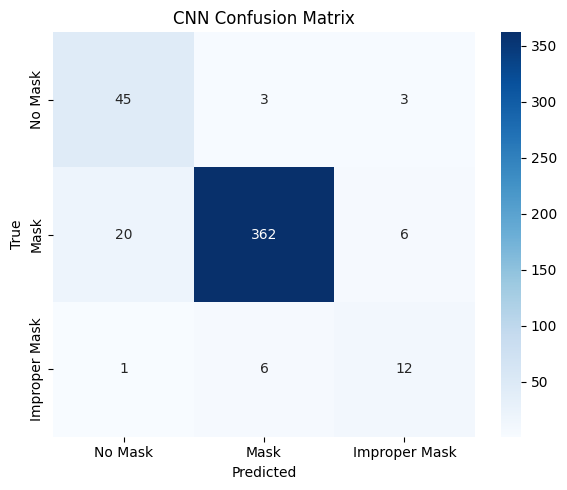


KNN + HOG Evaluation
Test Accuracy: 0.8362
               precision    recall  f1-score   support

      No Mask       0.53      0.69      0.60        51
         Mask       0.95      0.87      0.91       388
Improper Mask       0.31      0.63      0.41        19

     accuracy                           0.84       458
    macro avg       0.60      0.73      0.64       458
 weighted avg       0.88      0.84      0.85       458



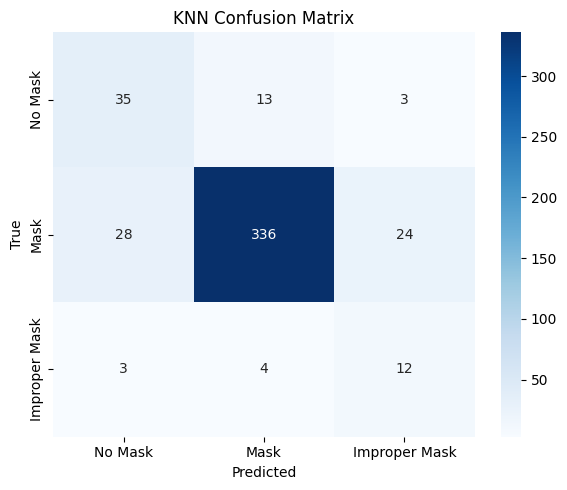

/tmp/ipykernel_445/292844546.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(model_path, map_location=device)



MLP + HOG Evaluation
Test Accuracy: 0.8537
               precision    recall  f1-score   support

      No Mask       0.52      0.73      0.61        51
         Mask       0.95      0.89      0.92       388
Improper Mask       0.38      0.53      0.44        19

     accuracy                           0.85       458
    macro avg       0.62      0.71      0.66       458
 weighted avg       0.88      0.85      0.86       458



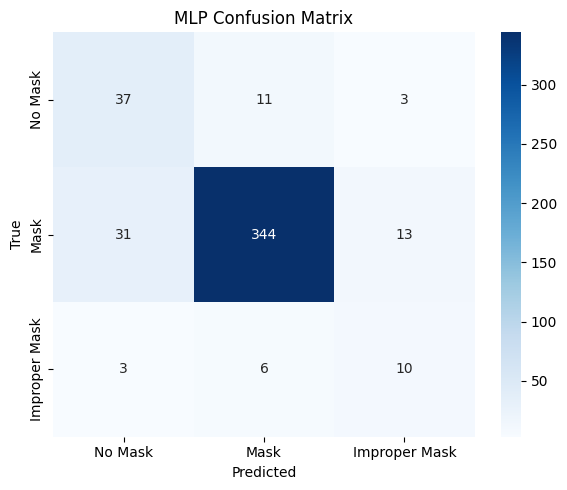


SVM + HOG Evaluation
Test Accuracy: 0.7533
               precision    recall  f1-score   support

      No Mask       0.32      0.53      0.40        51
         Mask       0.91      0.80      0.85       388
Improper Mask       0.23      0.42      0.30        19

     accuracy                           0.75       458
    macro avg       0.49      0.58      0.52       458
 weighted avg       0.82      0.75      0.78       458



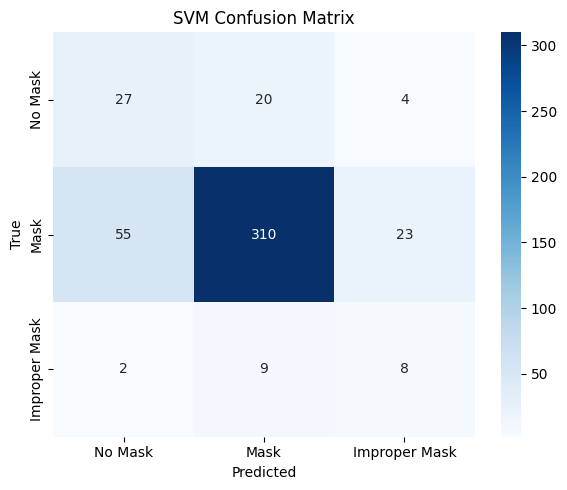

In [35]:
#run all evaluations
project_root = Path().resolve().parent
test_img_path = project_root / "ModifiedDataset" / "test" / "images"
test_lbl_path = project_root / "ModifiedDataset" / "test" / "labels"

#CNN
cnn_model_path = project_root / "Models" / "cnn_final_model.pt"
evaluate_cnn(cnn_model_path, test_img_path, test_lbl_path)

#KNN
knn_model_path = project_root / "models" / "knn_hog_final_model.joblib"
scaler_path = project_root / "models" / "knn_hog_scaler.joblib"
params_path = project_root / "models" / "knn_hog_best_params.joblib"
evaluate_knn(knn_model_path, scaler_path, params_path, test_img_path, test_lbl_path)

#MLP
mlp_model_path = project_root / "models" / "mlp_hog_weights_dict.pth"
mlp_scaler_path = project_root / "models" / "mlp_hog_scaler.joblib"
mlp_params_path = project_root / "models" / "mlp_hog_best_params.joblib"
evaluate_mlp(mlp_model_path, mlp_scaler_path, mlp_params_path, test_img_path, test_lbl_path)


#SVM
svm_model_path = project_root / "models" / "svm_hog_model.joblib"
svm_scaler_path = project_root / "models" / "svm_hog_scaler.joblib"
svm_params_path = project_root / "models" / "svm_hog_params.joblib"  
evaluate_svm(svm_model_path, svm_scaler_path, svm_params_path, test_img_path, test_lbl_path)





# Comparing models qualitatively

/tmp/ipykernel_445/2330865900.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


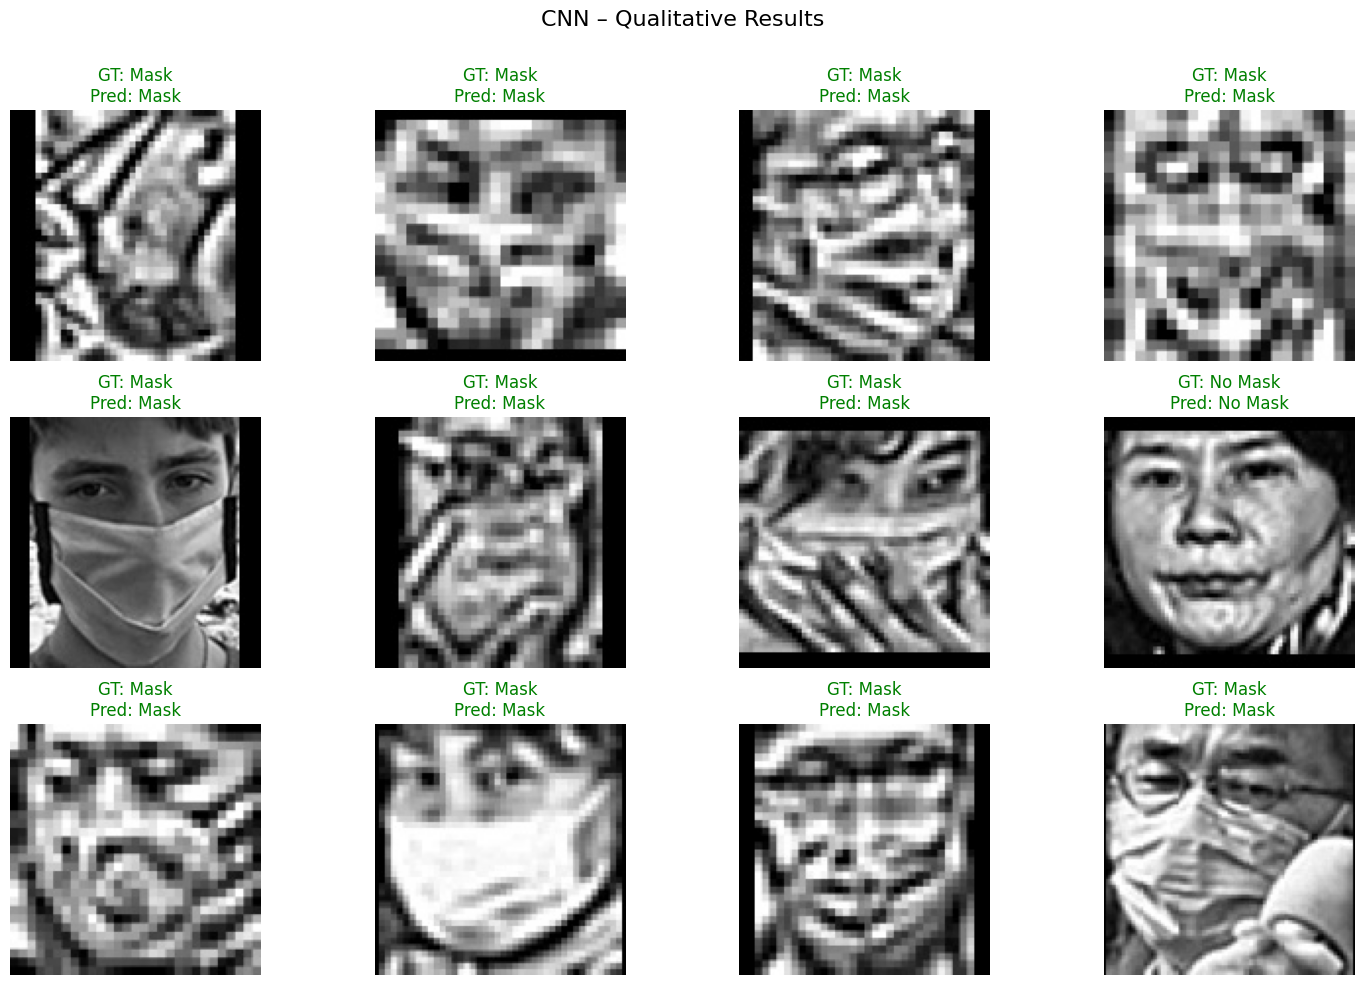

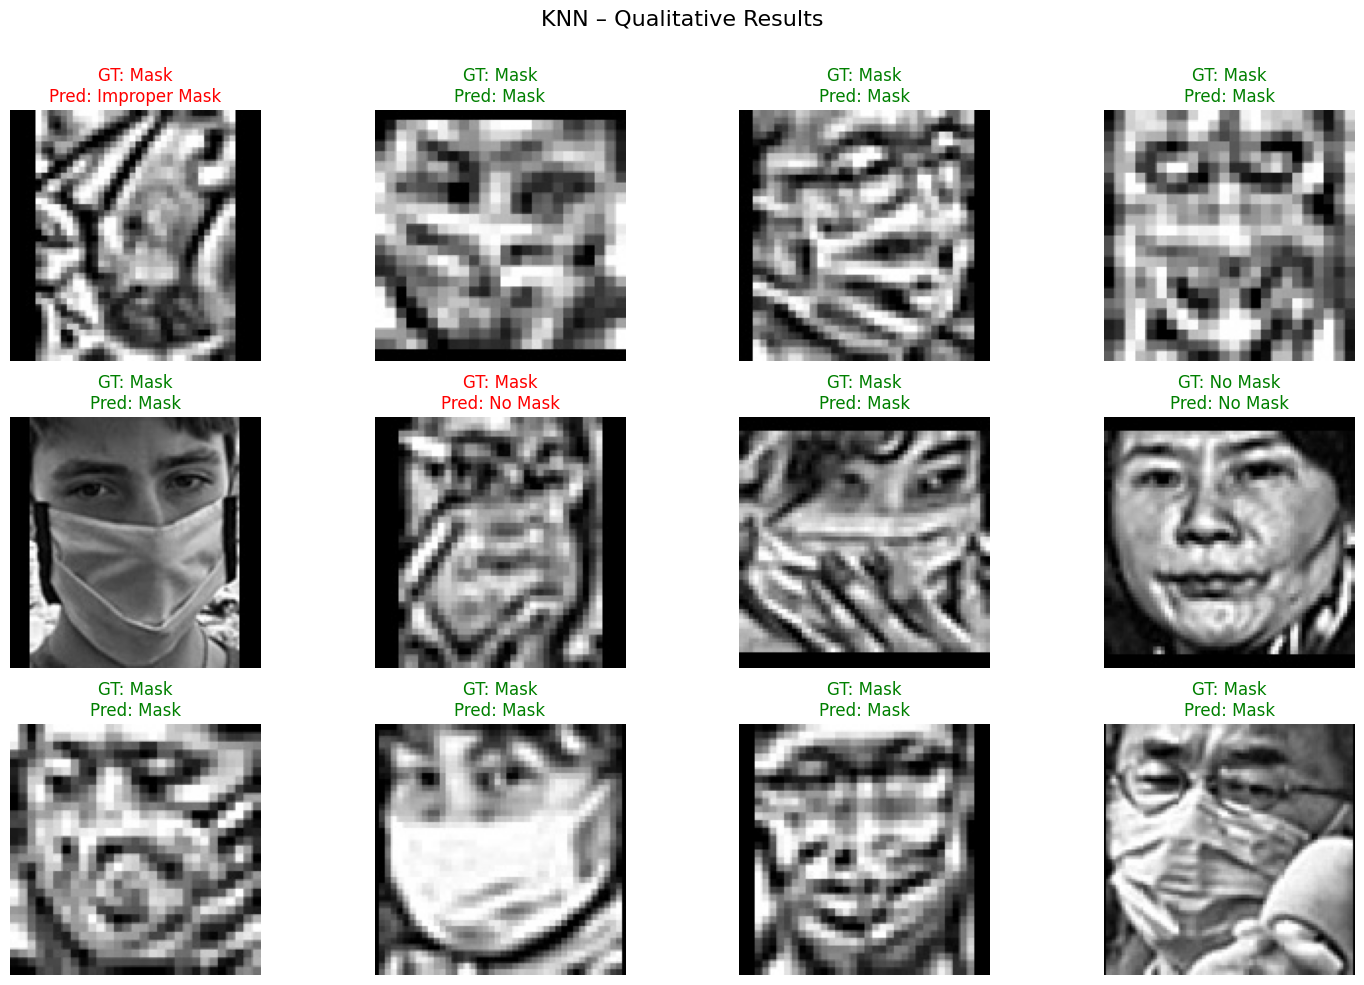

/tmp/ipykernel_445/2330865900.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(model_path, map_location=device)


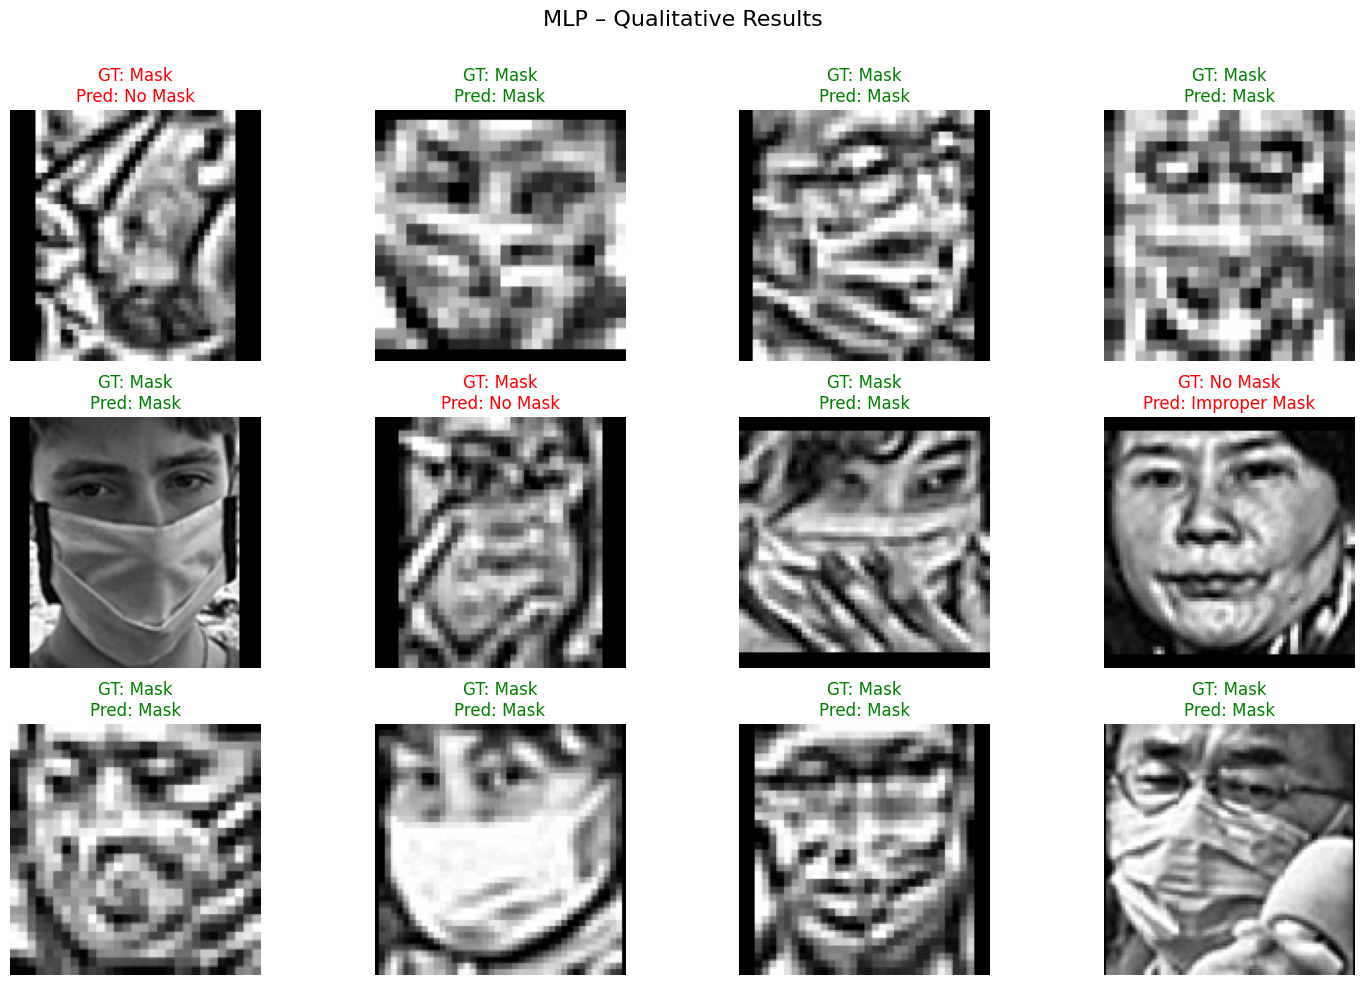

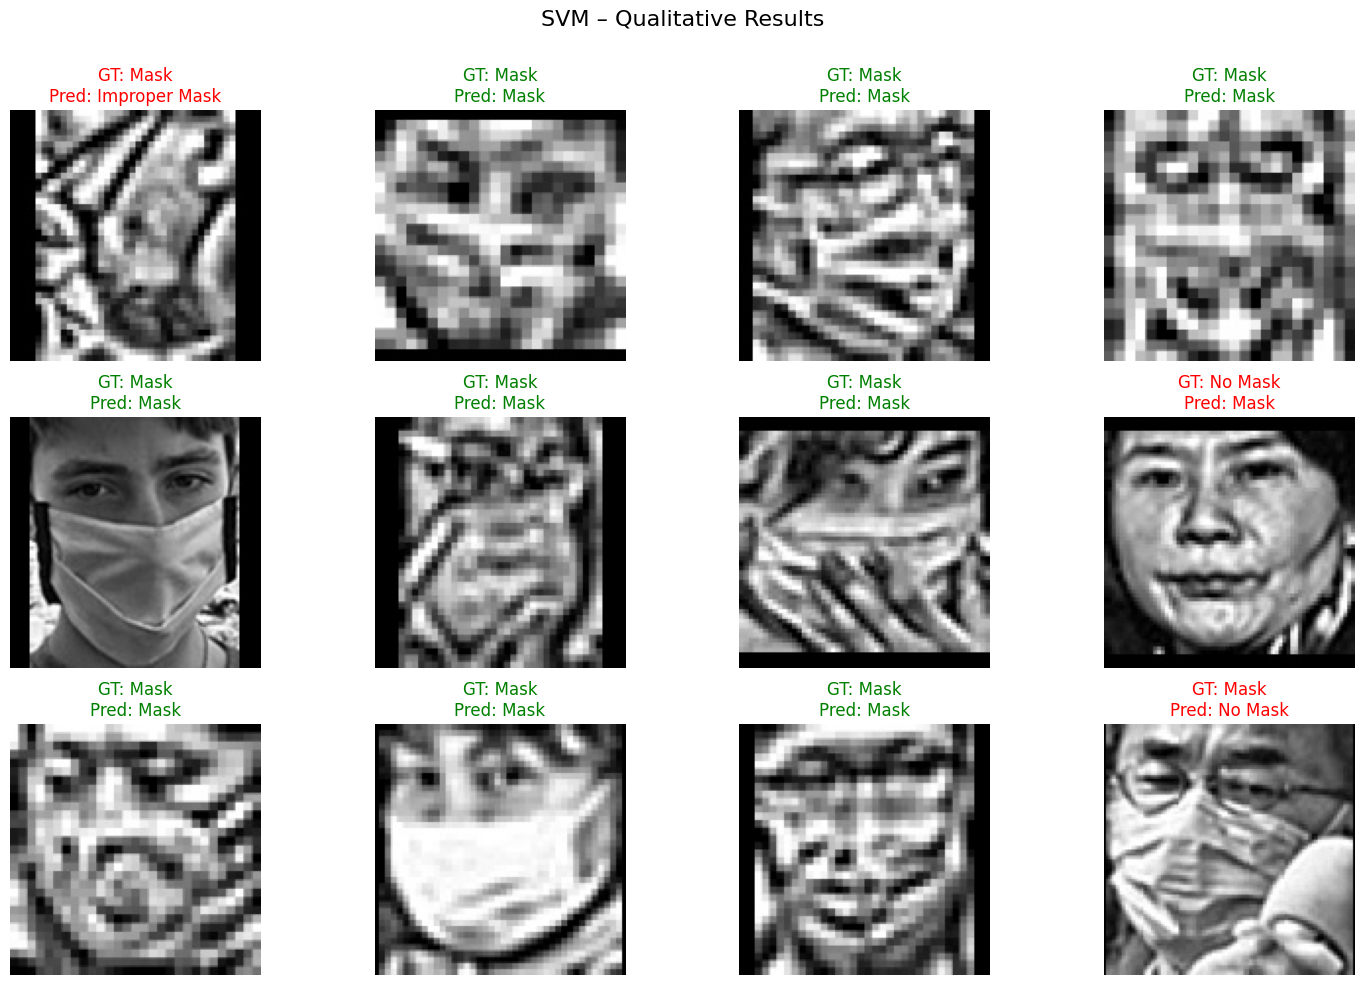

In [39]:
#setting up paths
project_root = Path().resolve().parent
test_img_path = project_root / "ModifiedDataset" / "test" / "images"
test_lbl_path = project_root / "ModifiedDataset" / "test" / "labels"

cnn_model_path = project_root / "Models" / "cnn_final_model.pt"
knn_model_path = project_root / "models" / "knn_hog_final_model.joblib"
scaler_path = project_root / "models" / "knn_hog_scaler.joblib"
params_path = project_root / "models" / "knn_hog_best_params.joblib"

mlp_model_path = project_root / "models" / "mlp_hog_weights_dict.pth"
mlp_scaler_path = project_root / "models" / "mlp_hog_scaler.joblib"
mlp_params_path = project_root / "models" / "mlp_hog_best_params.joblib"

svm_model_path = project_root / "models" / "svm_hog_model.joblib"
svm_scaler_path = project_root / "models" / "svm_hog_scaler.joblib"
svm_params_path = project_root / "models" / "svm_hog_params.joblib"

# func to visualize predictions of each model against test set random set of imgs
def visualize_predictions(image_paths, true_labels, preds, model_name, class_names=["No Mask", "Mask", "Improper Mask"], max_images=12):
    import random
    random.seed(42)
    indices = random.sample(range(len(image_paths)), min(max_images, len(image_paths)))
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        true_label = class_names[true_labels[idx]]
        pred_label = class_names[preds[idx]]
        correct = (true_label == pred_label)

        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(f"GT: {true_label}\nPred: {pred_label}", color='green' if correct else 'red')
        plt.axis('off')

    plt.suptitle(f"{model_name} – Qualitative Results", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# CNN vis
def qualitative_cnn(model_path, img_dir, lbl_dir):
    paths, labels = load_test_dataset(img_dir, lbl_dir)
    loader = create_cnn_dataloader(paths, labels)
    model = build_cnn_model()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    preds = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            out = model(x)
            preds.extend(out.argmax(1).cpu().numpy())
    visualize_predictions(paths, labels, preds, "CNN")

# KNN vis
def qualitative_knn(model_path, scaler_path, params_path, img_dir, lbl_dir):
    paths, labels = load_test_dataset(img_dir, lbl_dir)
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    params = joblib.load(params_path)

    ppc = (params["ppc_x"], params["ppc_y"])
    cpb = (params["cpb_x"], params["cpb_y"])
    stride = (params["stride_x"], params["stride_y"])
    orientations = params["orientations"]

    features = extract_hog_features_for_knn(paths, orientations, ppc, cpb, stride)
    features_scaled = scaler.transform(features)
    preds = model.predict(features_scaled)

    visualize_predictions(paths, labels, preds, "KNN")

# MLP vis
def qualitative_mlp(model_path, scaler_path, params_path, img_dir, lbl_dir):
    paths, labels = load_test_dataset(img_dir, lbl_dir)
    params = joblib.load(params_path)
    scaler = joblib.load(scaler_path)
    model_weights = torch.load(model_path, map_location=device)
    model_weights['train'] = False

    orientations = params["orientations"]
    ppc = (params["ppc_x"], params["ppc_y"])
    cpb = (params["cpb_x"], params["cpb_y"])
    features = extract_hog_features_for_mlp(paths, orientations, ppc, cpb)
    features_scaled = scaler.transform(features)

    with torch.no_grad():
        X_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
        preds = forward_mlp(X_tensor, model_weights).argmax(1).cpu().numpy()

    visualize_predictions(paths, labels, preds, "MLP")

# SVM vis
def qualitative_svm(model_path, scaler_path, params_path, img_dir, lbl_dir):
    paths, labels = load_test_dataset(img_dir, lbl_dir)
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    params = joblib.load(params_path)

    orientations = params["orientations"]
    ppc = params["pixels_per_cell"]
    cpb = params["cells_per_block"]
    features = extract_hog_features(paths, orientations, ppc, cpb)
    features_scaled = scaler.transform(to_numpy(features))
    preds = model.predict(features_scaled)

    visualize_predictions(paths, labels, preds, "SVM")


qualitative_cnn(cnn_model_path, test_img_path, test_lbl_path)
qualitative_knn(knn_model_path, scaler_path, params_path, test_img_path, test_lbl_path)
qualitative_mlp(mlp_model_path, mlp_scaler_path, mlp_params_path, test_img_path, test_lbl_path)
qualitative_svm(svm_model_path, svm_scaler_path, svm_params_path, test_img_path, test_lbl_path)
